In [83]:
%matplotlib inline
import sys

# Directories and paths
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
data_path = '/gpfswork/rech/xdy/uze68md/data/'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_meerkat/'

# Add library path to PYTHONPATH
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import fft
from galaxy2galaxy import problems
import tensorflow as tf
import galflow as gf
from scipy.signal import convolve
import cadmos_lib as cl
import pickle

tf.enable_eager_execution()

tf.version.VERSION

tf.executing_eagerly()

True

In [84]:
f = open(data_path+"meerkat_batch.pkl", "rb")
batch = pickle.load(f)
f.close()

In [85]:
model_name = 'unet_scales-4_steps-6500_epochs-20_growth_rate-12_batch_size-32_activationfunction-relu'
model = tf.keras.models.load_model(model_dir + model_name)#, compile=False)

In [86]:
# SET SCORE PARAMETERS

gamma = 0
n_row = batch['inputs'].shape[-2]
n_col = batch['inputs'].shape[-1]
n_shearlet = 3
n_maps = 100

U = cl.makeUi(n_row,n_col)
_,shearlets_adj = cl.get_shearlets(n_row
                                   ,n_col
                                   ,n_shearlet)
#Adjoint shealret transform of U, i.e Psi^{Star}(U)
psu = np.array([cl.convolve_stack(ui,shearlets_adj) for ui in U])
mu = cl.comp_mu(psu)

/gpfswork/rech/xdy/uze68md/GitHub/score/cadmos_lib.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff[s] = trafo.adjoint_transform(temp, do_norm=False)


In [87]:
def comp_grad(R,adj_U,mu,gamma):
    """This function returns the gradient of the differentiable part of the
    loss function.
    INPUT: R, 2D numpy array (residual)
           adj_U, 3D numpy array (adjoint shearlet transform of U)
           mu, 1D numpy array (weights associated to adj_U)
           gamma, scalar (trade-off between data-fidelity and shape constraint)
    OUTPUT: 2D numpy array"""
    temp = tf.zeros(R.shape,dtype=tf.dtypes.float32)
    for m,u in zip(mu,adj_U):
        for cst,im in zip(m,u):
            temp += cst*tf.keras.backend.sum(R*im)*im
    temp = gamma * temp + R
    return 2*temp

def unet(x):
    res = np.expand_dims(np.expand_dims(x, axis=0), axis=-1)
    res = tf.keras.backend.eval(np.squeeze(model(res)))
    return res

In [88]:
def eigenvalue(Op, v):
    """This function returns the scalar product of v and Op(v).
    INPUT: Op, function
           v, numpy array
    OUTPUT: scalar"""
    Op_v = Op(v)
    return (v*Op_v).sum()

def power_iteration(Op, output_dim,epsilon=0.001):
    """This function returns the norm of the operator using the power iteration
    method.
    INPUT: Op, function
           output_dim, tuple (dimension of the operator 2D entry)
           epsilon, positive float (error upper bound)
    OUTPUT: scalar"""
    d = np.prod(output_dim)

    v = np.ones(d,dtype=np.float32) / np.sqrt(d)
    v = v.reshape(output_dim)
    
    ev = eigenvalue(Op, v)

    while True:
        Op_v = Op(v)
        v_new = Op_v / np.linalg.norm(Op_v)

        ev_new = eigenvalue(Op, v_new)
        if np.abs(ev - ev_new) < epsilon:
            break

        v = v_new
        ev = ev_new
        
    return ev_new, v_new

lambda_unet,_ = power_iteration(unet,output_dim=(64,64))

In [122]:
def nmse(signal_1, signal_2):

    return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)

def fftconvolve(image, kernel):

    image = tf.expand_dims(tf.expand_dims(image, axis=0), axis=-1)
    kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)
    result = tf.cast(tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME'), tf.float32)
    return tf.squeeze(result)

# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)
 
    
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# # The gradient
# def grad(y, x_rec, psf):

#     return Ht(H(x_rec, psf) - y, psf)

# The gradient
def grad(y, x_rec, psf):
    res = H(x_rec, psf) - y
    res = comp_grad(res,psu,mu,gamma)
    res = Ht(res, psf)
    return res

# The cost function
def cost_func(y, x_rec, psf, var):

    L_d = (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2      
    return tf.keras.backend.eval(L_d)


# Spectral value
def max_sv(psf):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H)
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(sv):

    return (tf.cast(1.0, tf.float32) / 
            (sv * tf.cast(1.0 + 1.0e-5, tf.float32)))


def runFBS(y, x_0, psf, grad, sigma_noise, disp_step, n_iter, model):    

    # Convert arrays to tensors 
    x_0 = tf.cast(x_0, tf.float32)
    x_k = x_0
  
    # declare variables    
    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = tf.zeros(tf.shape(y.shape), tf.float32)
    
    sigma = tf.cast(sigma_noise, tf.float32)
    
    sv = max_sv(psf)
    alpha = get_alpha(sv)

    for k in range(n_iter):
        
        ## Gradient Descent update  
        x_k1 = x_k - alpha * grad(y, x_k, psf)   
#         x_k1 = soft_thresh(x_k1, 2*np.mean([np.std(x_k1[-30:,-30:]), np.std(x_k1[:30,:30]), 
#                                             np.std(x_k1[:30,-30:]), np.std(x_k1[-30:,:30])]))
        
        # U-Net Denoising
        x_k1 = tf.expand_dims(tf.expand_dims(x_k1, axis=0), axis=-1)
        x_k1 = tf.cast(tf.squeeze(model(x_k1)), tf.float32) #* lambda_unet
        
        ## Cost
        cost.append(cost_func(y, x_k1, psf, var=sigma**2))          
    
        # Update variables
        x_k = x_k1
                
        # Reconstruction
        final_im = x_k
                       
        # Compute NMSE
        nmse_arr[k] = nmse(gal_target_tf, final_im)       
        
#         # Check if optimal reconstruction is achieved
#         if nmse_arr[k]==np.min(nmse_arr):
#             x_opt = final_im
    
        x_opt = final_im
           
#         # Display plots
#         if (k+1)%disp_step==0:
#             plot_utils.plot_iter(final_im, gal_target, y, k+1)
                 
    return x_opt, cost, nmse_arr

In [181]:
n_iter = 5
disp_step = 20

gal_num = 58

x_0 = np.squeeze(batch['inputs_tikho'][gal_num])


# Deconvolve given image

gal_input = np.squeeze(batch['inputs'][gal_num])
gal_target = np.squeeze(batch['targets'][gal_num])
psf = np.squeeze(batch['psf'][gal_num])
sigma_noise = cl.sigma_mad(batch['inputs'][gal_num])
SNR = np.max(batch['inputs'][gal_num])/sigma_noise

print('\n\n Gal_ind = {} | SNR = {}'.format(gal_num, SNR))

# Cast numpy arrays to tensors
gal_input_tf = tf.cast(gal_input, tf.float32)
psf_tf = tf.cast(psf, tf.float32) 
gal_target_tf = tf.cast(gal_target, tf.float32)

# Deconvolve the image
x_opt, cost, nmse_arr = runFBS(gal_input_tf, x_0, psf_tf, grad, sigma_noise, 
                                disp_step, n_iter, model)



 Gal_ind = 58 | SNR = 26.088581967169677


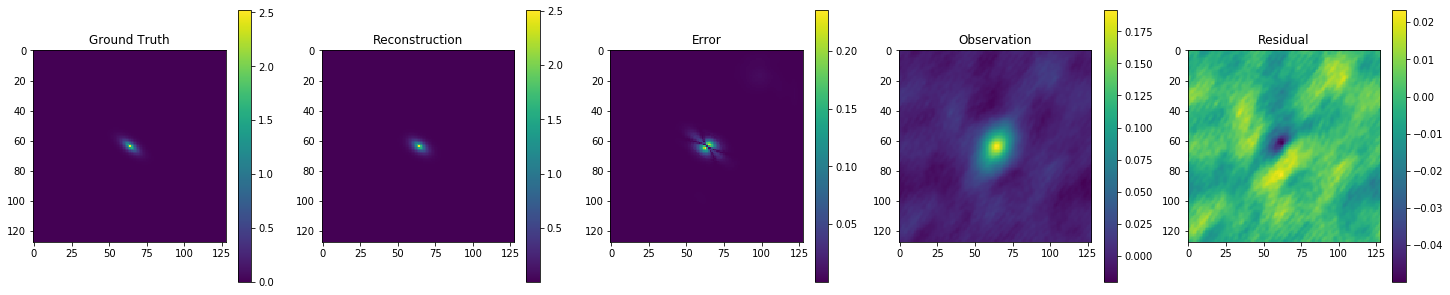

In [182]:
plt.figure(figsize=(25,5))
plt.subplot(151)
plt.imshow(gal_target)
plt.colorbar()
plt.title('Ground Truth')
plt.subplot(152)
plt.imshow(x_opt)
plt.colorbar()
plt.title('Reconstruction')
plt.subplot(153)
plt.imshow(np.abs(gal_target-x_opt))
plt.colorbar()
plt.title('Error')
plt.subplot(154)
plt.imshow(gal_input)
plt.colorbar()
plt.title('Observation')
plt.subplot(155)
plt.imshow(gal_input-H(x_opt,psf))
plt.colorbar()
plt.title('Residual')
plt.show()

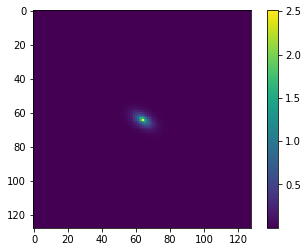

In [183]:
plt.imshow(x_opt);plt.colorbar()

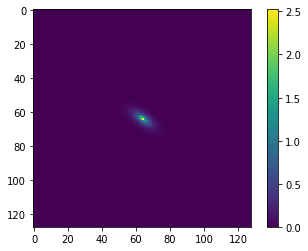

In [184]:
plt.imshow(gal_target);plt.colorbar()

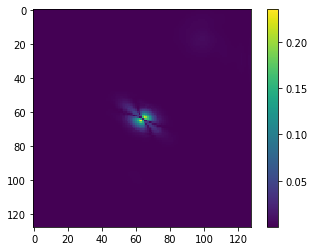

In [185]:
plt.imshow(np.abs(gal_target-x_opt));plt.colorbar()

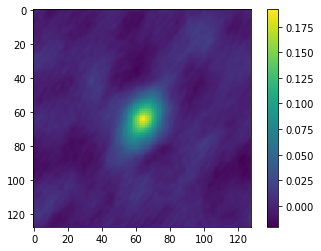

In [186]:
plt.imshow(gal_input);plt.colorbar()

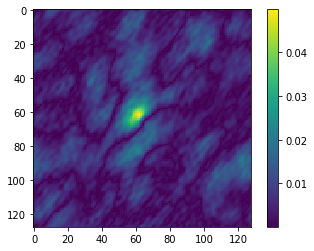

In [187]:
plt.imshow(np.abs(gal_input-H(x_opt,psf)));plt.colorbar()

(array([  2.,   2.,   0.,   0.,   5.,   3.,   0.,   1.,   3.,   1.,   3.,
          1.,   0.,   5.,   5.,   2.,   3.,   5.,   1.,   3.,   5.,   3.,
          5.,   5.,   3.,   4.,   4.,   5.,   9.,  11.,   5.,   5.,   5.,
         10.,   6.,   6.,  13.,  12.,  14.,  17.,  13.,  14.,  20.,  20.,
         23.,  36.,  60.,  77., 109., 138., 145., 180., 213., 241., 235.,
        264., 316., 359., 421., 464., 515., 563., 628., 656., 678., 665.,
        765., 772., 750., 704., 635., 657., 582., 559., 512., 464., 421.,
        362., 319., 254., 188., 193., 170., 160., 168., 103.,  85.,  75.,
         52.,  47.,  40.,  26.,  24.,  18.,  17.,   4.,   8.,   0.,   4.,
          1.]),
 array([-0.04982401, -0.04909302, -0.04836202, -0.04763102, -0.04690002,
        -0.04616902, -0.04543802, -0.04470702, -0.04397602, -0.04324502,
        -0.04251402, -0.04178302, -0.04105202, -0.04032102, -0.03959002,
        -0.03885902, -0.03812803, -0.03739703, -0.03666603, -0.03593503,
        -0.03520403, -0.03

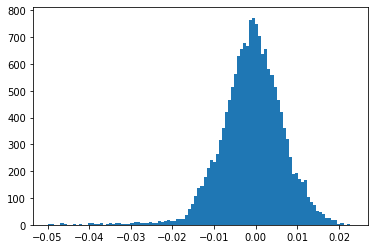

In [188]:
plt.hist(tf.keras.backend.eval(gal_input-H(x_opt,psf)).flatten(),bins=100)

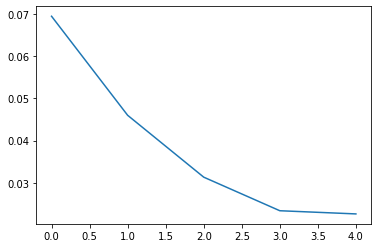

In [189]:
plt.plot(nmse_arr)

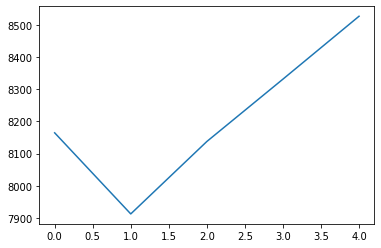

In [190]:
plt.plot(cost)